In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
path = tf.keras.utils.get_file('sunspots.csv', 
                               '  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')
print (path)

C:\Users\Amir\.keras\datasets\sunspots.csv


In [3]:
import csv
time_step = []
sunspots = []

with open(path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

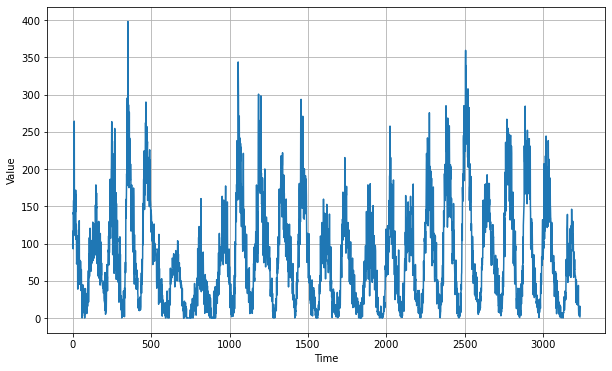

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle=True)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [11]:
window_size = 64
batch_size = 256
n_features = 1

In [12]:
x_train = x_train.reshape((len(x_train), n_features))

In [13]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle=True)

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [17]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [18]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
history = model.fit(generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 3s 214ms/step - loss: 339.4070 - mae: 339.9070
Epoch 2/100
12/12 [==============================] - 3s 253ms/step - loss: 312.9289 - mae: 313.4289
Epoch 3/100
12/12 [==============================] - 3s 237ms/step - loss: 282.3846 - mae: 282.8846
Epoch 4/100
12/12 [==============================] - 3s 260ms/step - loss: 252.1091 - mae: 252.6091
Epoch 5/100
12/12 [==============================] - 3s 262ms/step - loss: 224.5506 - mae: 225.0506
Epoch 6/100
12/12 [==============================] - 3s 240ms/step - loss: 185.4972 - mae: 185.9972
Epoch 7/100
12/12 [==============================] - 2s 193ms/step - loss: 147.6970 - mae: 148.1970
Epoch 8/100
12/12 [==============================] - 2s 198ms/step - loss: 138.5465 - mae: 139.0465
Epoch 9/100
12/12 [==============================] - 2s 205ms/step - loss: 131.8976 - mae: 132.3976
Epoch 10/100
12/12 [==============================] - 3s 220ms/step - loss: 126.8680 - mae: 127.3679

(1e-08, 0.0001, 0.0, 60.0)

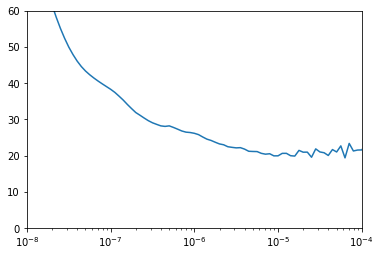

(1e-08, 0.0001, 0.0, 60.0)

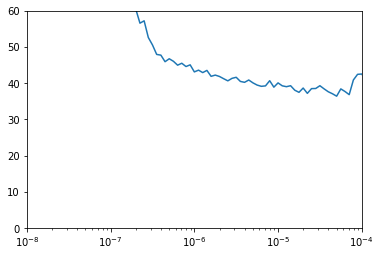

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


#train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle=True)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [22]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(generator,epochs=500)

Epoch 1/500
12/12 [==============================] - 2s 194ms/step - loss: 100.4039 - mae: 100.9027
Epoch 2/500
12/12 [==============================] - 2s 192ms/step - loss: 50.8246 - mae: 51.3223
Epoch 3/500
12/12 [==============================] - 2s 196ms/step - loss: 47.9091 - mae: 48.4072
Epoch 4/500
12/12 [==============================] - 2s 193ms/step - loss: 45.8783 - mae: 46.3760
Epoch 5/500
12/12 [==============================] - 2s 190ms/step - loss: 43.0292 - mae: 43.5266
Epoch 6/500
12/12 [==============================] - 2s 202ms/step - loss: 41.9298 - mae: 42.4271
Epoch 7/500
12/12 [==============================] - 3s 255ms/step - loss: 42.0744 - mae: 42.5717
Epoch 8/500
12/12 [==============================] - 3s 251ms/step - loss: 39.7180 - mae: 40.2152
Epoch 9/500
12/12 [==============================] - 3s 215ms/step - loss: 41.4464 - mae: 41.9435
Epoch 10/500
12/12 [==============================] - 2s 198ms/step - loss: 40.3877 - mae: 40.8847
Epoch 11/500
12/1

In [23]:
# We need to make it 2 dimimention - because RNN needs 3D
#series_2d = np.array(df['Sunspots'])
series_2d = np.array(sunspots)
print(series_2d.shape)
series_2d = series_2d.reshape((len(series_2d), n_features))
print(series_2d.shape)

(3235,)
(3235, 1)


In [24]:
rnn_forecast = model_forecast(model, series_2d[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

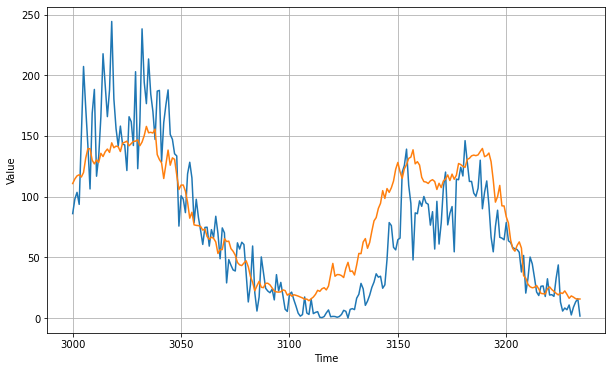

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

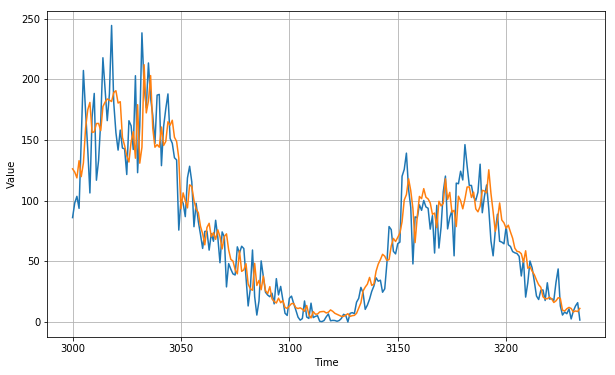

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

23.765215

<Figure size 432x288 with 0 Axes>

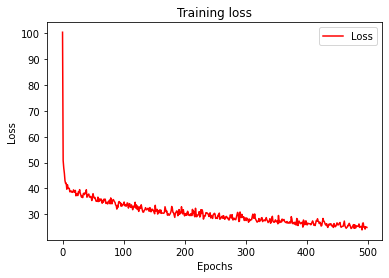

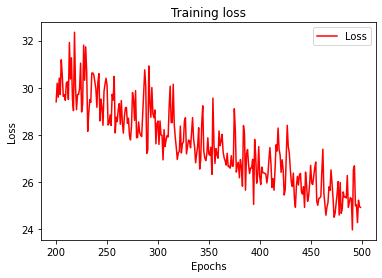

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
#print(rnn_forecast)

[1.80334488e+02 1.65932495e+02 2.21385651e+02 2.02602341e+02
 1.95812378e+02 1.66568024e+02 1.72221893e+02 1.72351089e+02
 1.71359238e+02 1.92315262e+02 1.79430908e+02 1.90465561e+02
 1.70150406e+02 1.54548752e+02 1.45760834e+02 1.52615173e+02
 1.56858536e+02 1.52650833e+02 1.31245773e+02 1.35252060e+02
 1.27649216e+02 9.58357544e+01 9.90672379e+01 8.83868637e+01
 8.30485153e+01 8.85051575e+01 8.65534286e+01 8.34583511e+01
 1.14608894e+02 1.31056335e+02 1.32336349e+02 1.03073143e+02
 9.93796616e+01 1.11037933e+02 8.51060486e+01 8.48528519e+01
 7.69715576e+01 6.63921509e+01 5.09542046e+01 4.30102539e+01
 4.26469612e+01 3.53892822e+01 4.97657166e+01 5.25579033e+01
 6.69459915e+01 4.63514252e+01 4.48055305e+01 4.08606110e+01
 4.48441048e+01 3.97551613e+01 2.68832245e+01 2.22263908e+01
 3.32603378e+01 1.98383331e+01 3.29938431e+01 2.01695232e+01
 3.07538300e+01 2.96630077e+01 1.91891308e+01 1.61151085e+01
 1.49790630e+01 1.13105726e+01 6.95184612e+00 1.25114498e+01
 8.35816765e+00 8.356638